In [ ]:
pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 2.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import time
import os

from io import BytesIO
from PIL import Image

In [ ]:
os.path.abspath('')

'/Users/jason/Documents/RL_GA_Analysis/cart_pole/GA'

Big parameters

In [ ]:
pop_size = 200
half_pop_size = int(pop_size/2)
max_moves = 500

Initial population creation

In [ ]:
population = np.random.choice([0,1], (pop_size, max_moves))

###GA functions

The fitness will be extracted directly from the environment as the number of moves performed before the end of the episode

In [ ]:
def fitness_selection(fitnesses):
  half_pop_size = int(len(fitnesses)/2)
  pairs = np.random.choice(range(len(fitnesses)), size=(half_pop_size, 2), p=fitnesses/sum(fitnesses))
  return pairs

def rank_selection(fitnesses):
  half_pop_size = int(len(fitnesses)/2)
  pairs = np.random.choice(range(len(fitnesses)), size=(half_pop_size, 2), p=np.argsort(fitnesses)/sum(range(len(fitnesses))))
  return pairs

In [ ]:
def crossover(pairs, population):
  pop_size = population.shape[0]

  new_gen = np.empty((pop_size, max_moves))
  for pair_nb in range(pairs.shape[0]):
    pair = pairs[pair_nb]
    dad = population[pair[0],:]
    mom = population[pair[1],:]

    for i in range(max_moves):
      if np.random.choice([True,False]):
        new_gen[2*pair_nb, i] = dad[i]
        new_gen[2*pair_nb+1, i] = mom[i]
      else:
        new_gen[2*pair_nb, i] = mom[i]
        new_gen[2*pair_nb+1, i] = dad[i]

  return new_gen

In [ ]:
def mutation(population, mutation_rate):
  pop_size = population.shape[0]

  for i in range(pop_size):
    for j in range(max_moves):

      if np.random.random() <= mutation_rate:
        population[i,j] = 1-population[i,j]
  return population

In [ ]:
def pop_diversity(population):
  return np.std(population, 0).mean()

###Environment functions

In [ ]:
def play_gen(population, env, random_seed_array):
  pop_size = population.shape[0]
  fitnesses = np.empty(pop_size)
  for i in range(pop_size):
    env.reset(seed=int(random_seed_array[i]))

    for t in range(max_moves):
      action = population[i,t]
      observation, reward, done, info, blc = env.step(action)

      if done : break

    fitnesses[i]=t

  return fitnesses

###Environment creation

In [ ]:
env = gym.make("CartPole-v1")
population = np.random.choice([0,1], (pop_size, max_moves))

In [ ]:
class GA_agent():

  def __init__(self, selection, nb_gen, pop_size, mutation_rate, elitism=0):
    if selection == "rank" : self.select = rank_selection
    elif selection=="fitness" : self.select = fitness_selection
    else : return "Unknown selection method"

    self.nb_gen = nb_gen
    self.pop_size = pop_size
    self.population = np.random.choice([0,1], (pop_size, max_moves))
    self.mutation_rate = mutation_rate
    self.elitism = elitism

    self.best_score = 0

    self.best_scores = np.empty(nb_gen)
    self.avg_scores = np.empty(nb_gen)
    self.diversity = np.empty(nb_gen)
    self.time_samples = np.empty(nb_gen)

    # if exists the file data/random_seed.npy, load it
    if os.path.exists('../data/random_seed.npy'):
      self.random_seed_array = np.load('../data/random_seed.npy')
    else:
      self.random_seed_array = np.random.randint(0, 2**32, 10000)
    self.current_random_seed = 0

  def evolve(self, env = gym.make("CartPole-v1")):

    last_time = time.time()
    self.start_time  = last_time
    start_time = last_time

    for i in range(self.nb_gen):

      self.population = self.population.astype(int)

      self.diversity[i] = pop_diversity(self.population)

      fit = play_gen(self.population, env, self.random_seed_array[self.current_random_seed: self.current_random_seed + self.pop_size])
      self.current_random_seed += self.pop_size

      if max(fit) > self.best_score: self.best_score = max(fit)

      now = time.time()
      self.time_samples[i] = now - start_time

      self.elite = self.population[np.argmax(fit)].copy()

      self.best_scores[i] = max(fit)
      self.avg_scores[i] = np.mean(fit)

      # Selection
      pairs = self.select(fit)
      # Crossover
      self.population = crossover(pairs, self.population)
      # Mutation
      self.population = mutation(self.population, self.mutation_rate)
      # Elitism
      self.population[np.random.choice(range(self.pop_size))] = self.elite

    env.close()


  def plot_evolution(self):
    plt.plot(self.best_scores, label="Best score")
    plt.plot(self.avg_scores, label="Average score")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over time")
    plt.savefig(f'plots/GA_evolution_{self.start_time}.png')
    plt.show()

  def plot_evolution_per_second(self):
    plt.plot(self.time_samples, self.best_scores, label="Max scores")
    plt.plot(self.time_samples, self.avg_scores, label="Mean score")
    plt.legend()
    plt.xlabel("Seconds of training")
    plt.ylabel("Fitness")
    plt.title("Fitness over training time")
    plt.savefig(f'plots/GA_evoluiton_per_second_{self.start_time}.png')
    plt.show()

  def plot_diversity(self):
    plt.plot(self.diversity, color="orange")
    plt.xlabel("Generation")
    plt.ylabel("Average gene STD")
    plt.title("Population diversity over time")
    plt.savefig(f'plots/GA_pop_diversity_{self.start_time}.png')
    plt.show()

  def save_metrics(self):
    name = f'data/GA_metrics_{self.start_time}.npy'
    metrics = np.array({
      "max" : self.best_scores,
      "avg" : self.avg_scores,
      "diversity" : self.diversity,
      "time": self.time_samples})
    np.save(name, metrics)


  def display_game(self, game = "CartPole-v1"):
    env = gym.make(game, render_mode="human")

    env.reset()
    frames = []
    for t in range(max_moves):
      action = self.elite[t]
      observation, reward, done, info, blc = env.step(action)
      frame = env.render()

      im = Image.fromarray(frame)

      frames.append(im)

      if done : break

    env.close()
    print(len(frames))

    animated_gif = BytesIO()
    frames[0].save(animated_gif,
                  format='GIF',
                  save_all=True,
                  append_images=frames[1:],      # Pillow >= 3.4.0
                  delay=0.1,
                  loop=0)
    animated_gif.seek(0,2)

    animated_gif.seek(0)
    ani = Image.open(animated_gif)
    ani.show()

    return frames

In [ ]:
nb_gen = 200
pop_size = 500
mutation_rate = 0.005

In [ ]:
agent = GA_agent("fitness", nb_gen, pop_size, mutation_rate)

In [ ]:
agent.evolve()

In [ ]:
#agent.display_game()

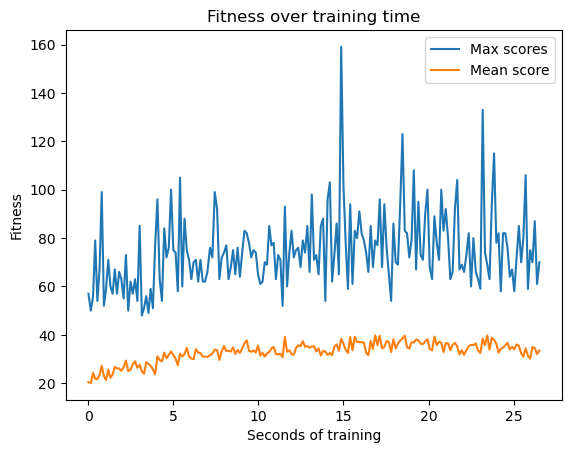

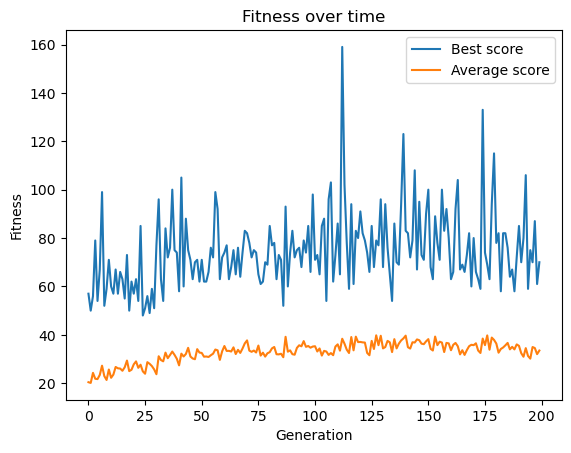

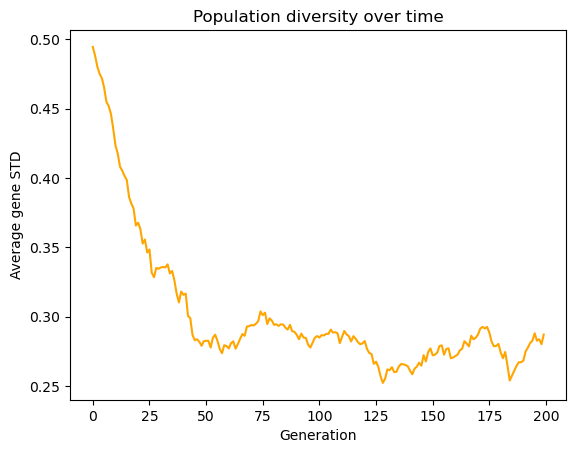

In [ ]:
agent.plot_evolution_per_second()
agent.plot_evolution()
agent.plot_diversity()

agent.save_metrics()

In [ ]:
#best = evolve("fitness", nb_gen, pop_size, mutation_rate)

In [ ]:
#play_gen(np.array([best]), env)